In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import joblib
from tensorflow.keras.models import load_model

In [14]:
# Load TSLA Data
data = yf.download('TSLA', start='2015-01-01', end='2024-10-31')

[*********************100%***********************]  1 of 1 completed


In [17]:
tsla_data = data[['Close']]
tsla_data.dropna(inplace=True)

C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_16604\2920378769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data.dropna(inplace=True)


In [18]:
# Train-Test Split (80% train, 20% test)
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]

In [19]:
test = test.dropna()
test.index = test.index.tz_convert('UTC')
test = test.squeeze()  # Convert to Series if it's a single-column DataFrame
test.index.name = 'Date'

In [30]:
# Load models
arima_model = joblib.load("arima_model.pkl")
sarima_model = joblib.load("sarima_model.pkl")
lstm_model = load_model("lstm_model.keras")

In [31]:
#  use for forecasting ARIMA, SARIMA,
model = arima_model  

# Forecast parameters
forecast_steps = 180  # For a 6-month forecast (assuming 30 trading days per month)


In [32]:
# Forecast with ARIMA 
def forecast_arima_sarima(model, steps):
    forecast = model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    return forecast_mean, confidence_intervals

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [39]:
# Ensure train and test are NumPy arrays and 2D
train = train.values if hasattr(train, 'values') else np.array(train)
test = test.values if hasattr(test, 'values') else np.array(test)

# Reshape to 2D (if necessary) and scale
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [40]:
# Forecast with LSTM

model = lstm_model
def forecast_lstm(model, test_data, steps, scaler):
    forecast_input = test_data[-1:]
    predictions = []

    for _ in range(steps):
        forecast_input = forecast_input.reshape((1, 1, 1))
        next_value = model.predict(forecast_input)
        forecast_input = np.append(forecast_input[:, :, 1:], next_value)
        predictions.append(next_value[0][0])

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

In [42]:


#  Call forecast function based on chosen model
if 'ARIMA' in str(type(model)) or 'SARIMA' in str(type(model)):
    forecast_mean, confidence_intervals = forecast_arima_sarima(model, forecast_steps)
    forecast_dates = pd.date_range(tsla_data.index[-1], periods=forecast_steps + 1, closed='right')
else:
    
    forecasted_values = forecast_lstm(model, test_scaled, forecast_steps, scaler)

    forecast_dates = pd.date_range(tsla_data.index[-1], periods=forecast_steps + 1, inclusive='right')
    forecast_mean = pd.Series(forecasted_values.flatten(), index=forecast_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

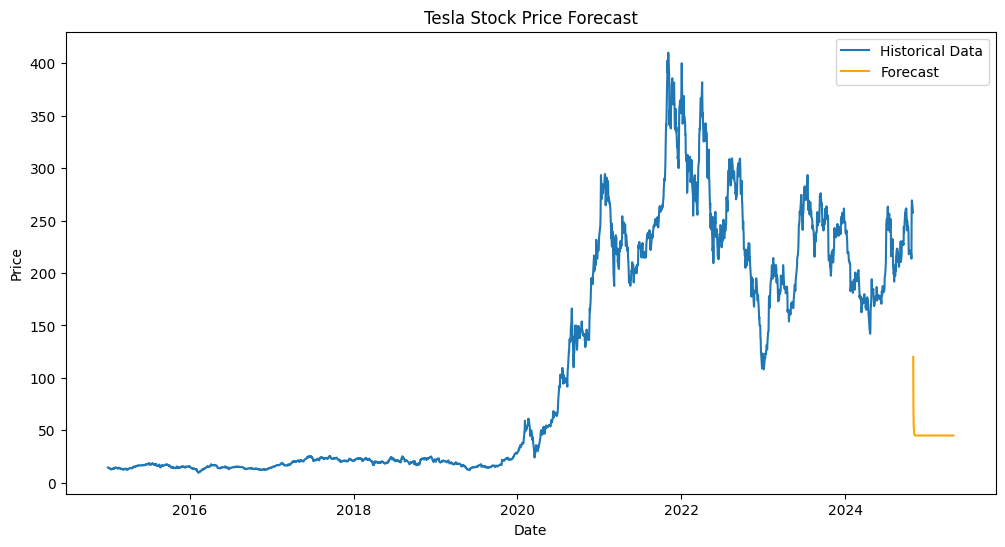

In [43]:
# Plot forecast vs historical data
plt.figure(figsize=(12, 6))
plt.plot(tsla_data['Close'], label='Historical Data')
plt.plot(forecast_dates, forecast_mean, label='Forecast', color='orange')
if 'confidence_intervals' in locals():
    plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                     color='orange', alpha=0.2, label='Confidence Interval')
plt.title("Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Evaluate trends, volatility, and potential risks based on forecast


In [44]:
# Trend Analysis
print("Trend Analysis:")
if forecast_mean.iloc[-1] > forecast_mean.iloc[0]:
    print("Upward trend expected.")
elif forecast_mean.iloc[-1] < forecast_mean.iloc[0]:
    print("Downward trend expected.")
else:
    print("Stable trend expected.")


Trend Analysis:
Downward trend expected.
